Top-Down
- theory informs what we collect
- academic or peer-reviewed research
- use the prior work of others
- can be biased if the investigator has certain theory(ies) that he or she wants to prove

Bottom-Up
- allow the data to tell you how to build the model based on the statistics you generate
- medical and criminology disciplines
- less temptation to allow your expectations to blind you to the realities of the data
- What if there is no data available (or not enough data) to adequately tell the truth of a phenomenon? What if the investigators miss some data that is available because of simple human error?

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('../Data/tweets_aws.csv')
df.head()

,Gender,Weekday,Hour,Day,Reach,RetweetCount,Klout,Sentiment,text
0,Male,Monday,23,2,4037,1,52,3.0,Amazon Web Services is becoming a nice predictable profit engine http://uk.businessinsider.com/amazon-web-services-profit-vs-total-amazon-profit-2016-5?nr_email_referer=1&utm_term=Tech%20Chart%20Of%20The%20Day?rUS&IR=T&utm_content=buffer364fd&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer http://twitter.com/rhunold/status/727376950239596544/photo/1
1,Unknown,Friday,12,4,524418,21,72,0.0,Announcing four new VPN features in our Sao Paulo Region. https://aws.amazon.com/about-aws/whats-new/2016/03/new-vpn-features-in-sao-paulo/?sc_channel=sm&sc_campaign=launches_2016&sc_publisher=tw_go&sc_content=vpn_sao_paulo&sc_country=global&sc_geo=global&sc_category=vpn&adbsc=social_20160304_58977686 http://twitter.com/awscloud/status/705830695155822592/photo/1
2,Unknown,Tuesday,9,31,1748,1,46,0.0,Are you an @awscloud user? Use #Zadara + #AWS to enahnce your storage just one click away! https://aws.amazon.com/marketplace/seller-profile/ref=dtl_pcp_sold_by?ie=UTF8&id=a35eb439-3c19-44e2-aae5-1f7eaedafa3a&utm_campaign=AWS%20One%20Click&utm_content=28677081&utm_medium=social&utm_source=twitter http://twitter.com/ZadaraStorage/status/737662953080651776/photo/1
3,Unknown,Saturday,3,27,1179,1,0,0.0,AWS CloudFormation Adds Support for Amazon VPC NAT Gateway Amazon EC2 Container Registry and More http://aws.amazon.com/about-aws/whats-new/2016/02/aws-cloudformation-adds-support-for-amazon-vpc-nat-gateway-amazon-ec2-container-registry-and-more/?sc_channel=sm&sc_campaign=launches_2016&sc_publisher=tw_go&sc_content=cf_nat_ecr_emr_es&sc_country=global via @nuzzel
4,Unknown,Saturday,3,27,1179,1,0,0.0,AWS CloudFormation Adds Support for Amazon VPC NAT Gateway Amazon EC2 Container Registry and More http://aws.amazon.com/about-aws/whats-new/2016/02/aws-cloudformation-adds-support-for-amazon-vpc-nat-gateway-amazon-ec2-container-registry-and-more/?sc_channel=sm&sc_campaign=launches_2016&sc_publisher=tw_go&sc_content=cf_nat_ecr_emr_es&sc_country=global via @nuzzel


In [2]:
print(df.shape)
df.drop_duplicates(subset=['text'], inplace=True)
df = df.loc[~df['text'].str.contains('RT @')]
print(df.shape)

(1000, 9)
(979, 9)


In [3]:
def re_mod(doc):
  import re
  doc = re.sub('\\S*@\\S*\\s?', '', doc)  # remove emails
  doc = re.sub('\\s+', ' ', doc)          # remove newline chars
  doc = re.sub("\\'", "", doc)            # remove single quotes
  doc = re.sub(r"http\S+", "url", doc)    # replace URLs with 'url'
  return doc

# Convert each tweet to a list of cleaned words and add to a master list
docs = df['text'].apply(lambda x: re_mod(x)).values.tolist()

# Print the first five records to see what they look like
for doc in docs[:5]:
  print(doc)

Amazon Web Services is becoming a nice predictable profit engine url url
Announcing four new VPN features in our Sao Paulo Region. url url
Are you an user? Use #Zadara + #AWS to enahnce your storage just one click away! url url
AWS CloudFormation Adds Support for Amazon VPC NAT Gateway Amazon EC2 Container Registry and More url via 
AWS database migration service now available: url


In [4]:
import spacy
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = nlp.Defaults.stop_words
stop_words_spacy |= {'AWS', 'Amazon', 'Web', 'Services', 'url', 'datum', 'service', 'security', 'check'}


In [5]:
def docs_lemma_stop(doc, stop_words):
  unigrams = []
  for unigram in doc: # remove stop words and punctuation
    if not unigram.text in stop_words:      # Check both versions of the word
      if not unigram.lemma_ in stop_words:  # Check both versions of the word
        if not unigram.is_punct:            # Remove punctuation
          unigrams.append(unigram.lemma_)   # append the lemmatized version
  return unigrams

# Call the function to remove stop words, punctuation and perform lemmatization on each doc
docs = [docs_lemma_stop(nlp(doc), stop_words_spacy) for doc in docs]

# Print the first five records to see what they look like
for doc in docs[:5]:
  print(doc)

# Amazon Web Services is becoming a nice predictable profit engine url url
# Announcing four new VPN features in our Sao Paulo Region. url url
# Are you an user? Use #Zadara + #AWS to enahnce your storage just one click away! url url
# AWS CloudFormation Adds Support for Amazon VPC NAT Gateway Amazon EC2 Container Registry and More url via
# AWS database migration service now available: url


['nice', 'predictable', 'profit', 'engine']
['announce', 'new', 'vpn', 'feature', 'Sao', 'Paulo', 'Region']
['user', 'use', 'Zadara', '+', 'enahnce', 'storage', 'click', 'away']
['CloudFormation', 'add', 'Support', 'VPC', 'NAT', 'Gateway', 'EC2', 'Container', 'Registry', 'More']
['database', 'migration', 'available']


In [6]:
import gensim

# gensim.models.Phrases ties together pairs of words that appear together in docs
bigram = gensim.models.Phrases(docs, min_count=5, threshold=10)

# Repeat the process using the bigrams + docs to train trigrams
trigram = gensim.models.Phrases(bigram[docs], min_count=5, threshold=10)

# Repeat the process using the bigrams + docs to train fourgrams
fourgram = gensim.models.Phrases(trigram[docs], min_count=5, threshold=10)

# These are "frozen" (i.e. immutable) versions of the same files that are quicker in memory
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
fourgram_mod = gensim.models.phrases.Phraser(fourgram)

In [7]:
def ngrams(docs):
  bigram = gensim.models.Phrases(docs, min_count=5, threshold=10)
  trigram = gensim.models.Phrases(bigram[docs], min_count=5, threshold=10)
  fourgram = gensim.models.Phrases(trigram[docs], min_count=5, threshold=10)

  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  fourgram_mod = gensim.models.phrases.Phraser(fourgram)

  docs = [bigram_mod[doc] for doc in docs]                # Add bigrams to each doc
  docs = [trigram_mod[bigram_mod[doc]] for doc in docs]   # Add trigrams
  docs = [fourgram_mod[trigram_mod[doc]] for doc in docs] # Add fourgrams

  return docs

# Call the function
docs = ngrams(docs)

# Print some samples to see what happened
for doc in docs[:5]:
  print(doc)

# ['nice', 'predictable', 'profit', 'engine']
# ['announce', 'new', 'vpn', 'feature', 'Sao', 'Paulo', 'Region']
# ['user', 'use', 'Zadara', '+', 'enahnce', 'storage', 'click', 'away']
# ['CloudFormation', 'add', 'Support', 'VPC', 'NAT', 'Gateway', 'EC2', 'Container', 'Registry', 'More']
# ['database', 'migration', 'service', 'available']

['nice', 'predictable', 'profit', 'engine']
['announce', 'new', 'vpn', 'feature', 'Sao_Paulo', 'Region']
['user', 'use', 'Zadara', '+', 'enahnce', 'storage', 'click', 'away']
['CloudFormation', 'add', 'Support', 'VPC', 'NAT', 'Gateway', 'EC2_Container', 'Registry', 'More']
['database', 'migration', 'available']


In [8]:
def filter_pos(docs, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
  docs_with_ngrams = [] # Create a new list to store the final docs

  # Filter each n-gram to include only the allowed parts of speech (pos) tags
  for doc in docs:
    doc = nlp(" ".join(doc)) # We have to concatenate the n-grams back together to do this
    docs_with_ngrams.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

  return docs_with_ngrams

# Call the function
docs = filter_pos(docs)

# Print some samples to see what happened
for doc in docs[:5]:
  print(doc)

['nice', 'predictable', 'profit', 'engine']
['announce', 'new', 'vpn', 'feature', 'Sao_Paulo', 'Region']
['user', 'use', 'Zadara', '+', 'enahnce', 'storage', 'click', 'away']
['CloudFormation', 'add', 'Support', 'VPC', 'NAT', 'Gateway', 'EC2_Container', 'Registry', 'more']
['database', 'migration', 'available']


READ 12.5 to learn more about LDA!

In [9]:
# Build dictionary and standard scopus

from gensim import corpora

id2word = corpora.Dictionary(docs)
for row in id2word.iteritems():
  print(row)

(0, 'engine')
(1, 'nice')
(2, 'predictable')
(3, 'profit')
(4, 'Region')
(5, 'Sao_Paulo')
(6, 'announce')
(7, 'feature')
(8, 'new')
(9, 'vpn')
(10, '+')
(11, 'Zadara')
(12, 'away')
(13, 'click')
(14, 'enahnce')
(15, 'storage')
(16, 'use')
(17, 'user')
(18, 'CloudFormation')
(19, 'EC2_Container')
(20, 'Gateway')
(21, 'NAT')
(22, 'Registry')
(23, 'Support')
(24, 'VPC')
(25, 'add')
(26, 'more')
(27, 'available')
(28, 'database')
(29, 'migration')
(30, 'AWSCloud10')
(31, 'celebrate')
(32, 'year')
(33, 'La')
(34, 'banda')
(35, 'con')
(36, 'cuenten')
(37, 'de')
(38, 'estos')
(39, 'los')
(40, 'm')
(41, 'operadore')
(42, 'permitirn')
(43, 'que')
(44, 'tre')
(45, 'usuarios')
(46, 'AWSSummitSG')
(47, 'Customers')
(48, 'IDA')
(49, 'Singapore')
(50, 'Zalora')
(51, 'amp')
(52, 'insight')
(53, 'learn')
(54, 'share')
(55, 'EMR')
(56, 'GitHub')
(57, 'Import')
(58, 'Zeppelin')
(59, 'json')
(60, 'new_BigData_Blog')
(61, 'note')
(62, 'Kinesis')
(63, 'Optimize')
(64, 'Spark')
(65, 'Streaming')
(66, 'proce

In [10]:
corpus = [id2word.doc2bow(text) for text in docs]
corpus

# ['nice', 'predictable', 'profit', 'engine']
# ['announce', 'vpn', 'feature', 'Sao_Paulo']
# ['user', 'Zadara', '+', 'enahnce', 'storage', 'click', 'away']
# ['CloudFormation', 'add', 'Support', 'VPC', 'NAT', 'Gateway', 'EC2_Container', 'Registry', 'more']
# ['database', 'migration', 'service']

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)],
 [(18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1)],
 [(27, 1), (28, 1), (29, 1)],
 [(30, 1), (31, 1), (32, 1)],
 [(33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1)],
 [(46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1)],
 [(55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1)],
 [(60, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1)],
 [(16, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1)],
 [(75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1)],
 [(53, 1), (84, 1), (85, 1), (86, 1), (87, 1)],
 [(7, 1), (8, 1), (88, 1), (89, 1), (90, 1), (91, 1)],
 [(92, 1),
  (93, 1),
  (

In [11]:
# Change the number of topics in the LDA here
topics = 4

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=topics,
                                            random_state=1,
                                            chunksize=20,
                                            passes=10,
                                            per_word_topics=True)

ldatopics = lda_model.show_topics(formatted=False)
for topic in lda_model.print_topics():
  print(topic)

(0, '0.040*"learn" + 0.029*"cloud" + 0.016*"stream" + 0.016*"webinar" + 0.013*"BigData" + 0.013*"Data" + 0.012*"iot" + 0.012*"gateway" + 0.012*"join" + 0.011*"manage"')
(1, '0.107*"amp" + 0.030*"AWSLaunch" + 0.028*"available" + 0.026*"use" + 0.018*"region" + 0.015*"Service" + 0.012*"add" + 0.012*"VPC" + 0.012*"redshift" + 0.012*"app"')
(2, '0.062*"support" + 0.054*"new" + 0.020*"EC2" + 0.018*"S3" + 0.017*"fast" + 0.013*"run" + 0.012*"Cloud" + 0.010*"version" + 0.010*"deploy" + 0.010*"feature"')
(3, '0.041*"CloudComputing" + 0.020*"RDS" + 0.018*"Region" + 0.016*"update" + 0.015*"cloudformation_support" + 0.014*"instance" + 0.012*"Regions" + 0.011*"awssummit" + 0.011*"awscloud" + 0.011*"Logs"')


In [12]:
from gensim.models import CoherenceModel

df_fit = pd.DataFrame(columns=['index', 'perplexity', 'coherence'])
df_fit.set_index('index', inplace=True)

for n in range(3,10):
  # Fit LDA model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=n,
                                              random_state=1,
                                              chunksize=100,
                                              passes=5,
                                              per_word_topics=True)

  # Generate fit metrics
  coherence = CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, coherence='c_v').get_coherence()
  perplexity = lda_model.log_perplexity(corpus)

  # Add metrics to df_fit
  df_fit.loc[n] = [perplexity, coherence]

df_fit

,perplexity,coherence
index,,
3,-7.620545,0.451335
4,-7.722801,0.487035
5,-7.805327,0.534271
6,-7.847100,0.557893
7,-7.892974,0.574929
8,-7.915789,0.557665
9,-7.957175,0.576046


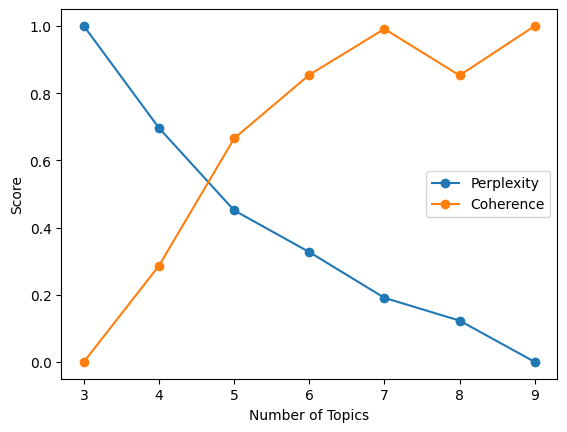

In [13]:
# Visualize results
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Normalize these scores to the same scale
scaler = MinMaxScaler()
df_fit[['perplexity', 'coherence']] = scaler.fit_transform(df_fit[['perplexity', 'coherence']])

plt.plot(df_fit.index, df_fit.perplexity, marker='o');
plt.plot(df_fit.index, df_fit.coherence, marker='o');
plt.legend(['Perplexity', 'Coherence'], loc='best')
plt.xlabel('Number of Topics')
plt.ylabel('Score')
plt.show()

In [14]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                              id2word=id2word,
                                              num_topics=7,
                                              random_state=1,
                                              chunksize=100,
                                              passes=5,
                                              per_word_topics=True)

df_topics = df.copy()

num_topics = len(lda_model.get_topics()) # store the number of topics from the last model
for col in range(num_topics): # generate a new column for each topic
  df_topics[f'topic_{col + 1}'] = 0.0

# Store the topic score and dominant topic
for i, words in enumerate(docs):
  doc = lda_model[id2word.doc2bow(words)] # generate a corpus for this document set of words

  for j, score in enumerate(doc[0]): # for each document in the corpus
    # Get the topic score and store it in the appropriate column
    df_topics.iat[i, (len(df_topics.columns) - ((num_topics) - score[0]))] = score[1]

df_topics.head()

,Gender,Weekday,Hour,Day,Reach,RetweetCount,Klout,Sentiment,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,Male,Monday,23,2,4037,1,52,3.0,Amazon Web Services is becoming a nice predictable profit engine http://uk.businessinsider.com/amazon-web-services-profit-vs-total-amazon-profit-2016-5?nr_email_referer=1&utm_term=Tech%20Chart%20Of%20The%20Day?rUS&IR=T&utm_content=buffer364fd&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer http://twitter.com/rhunold/status/727376950239596544/photo/1,0.028657,0.028656,0.028656,0.028655,0.028656,0.828064,0.028656
1,Unknown,Friday,12,4,524418,21,72,0.0,Announcing four new VPN features in our Sao Paulo Region. https://aws.amazon.com/about-aws/whats-new/2016/03/new-vpn-features-in-sao-paulo/?sc_channel=sm&sc_campaign=launches_2016&sc_publisher=tw_go&sc_content=vpn_sao_paulo&sc_country=global&sc_geo=global&sc_category=vpn&adbsc=social_20160304_58977686 http://twitter.com/awscloud/status/705830695155822592/photo/1,0.020428,0.020428,0.020432,0.877427,0.020428,0.020428,0.020429
2,Unknown,Tuesday,9,31,1748,1,46,0.0,Are you an @awscloud user? Use #Zadara + #AWS to enahnce your storage just one click away! https://aws.amazon.com/marketplace/seller-profile/ref=dtl_pcp_sold_by?ie=UTF8&id=a35eb439-3c19-44e2-aae5-1f7eaedafa3a&utm_campaign=AWS%20One%20Click&utm_content=28677081&utm_medium=social&utm_source=twitter http://twitter.com/ZadaraStorage/status/737662953080651776/photo/1,0.015912,0.904457,0.015955,0.015916,0.015922,0.015921,0.015918
3,Unknown,Saturday,3,27,1179,1,0,0.0,AWS CloudFormation Adds Support for Amazon VPC NAT Gateway Amazon EC2 Container Registry and More http://aws.amazon.com/about-aws/whats-new/2016/02/aws-cloudformation-adds-support-for-amazon-vpc-nat-gateway-amazon-ec2-container-registry-and-more/?sc_channel=sm&sc_campaign=launches_2016&sc_publisher=tw_go&sc_content=cf_nat_ecr_emr_es&sc_country=global via @nuzzel,0.014294,0.014293,0.014293,0.014293,0.014293,0.014293,0.914239
6,Unknown,Tuesday,17,15,591,1,41,0.0,AWS database migration service now available: http://aws.amazon.com/dms/?sc_channel=sm&sc_campaign=launches_2016&sc_publisher=tw_go&sc_content=dms_ga&sc_country=global&sc_geo=global&sc_category=dms&adbsc=social_20160315_59385266&adbid=709871357085921281&adbpl=tw&adbpr=1946428914&utm_content=buffer35f3e&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer,0.035715,0.785710,0.035715,0.035715,0.035715,0.035715,0.035715


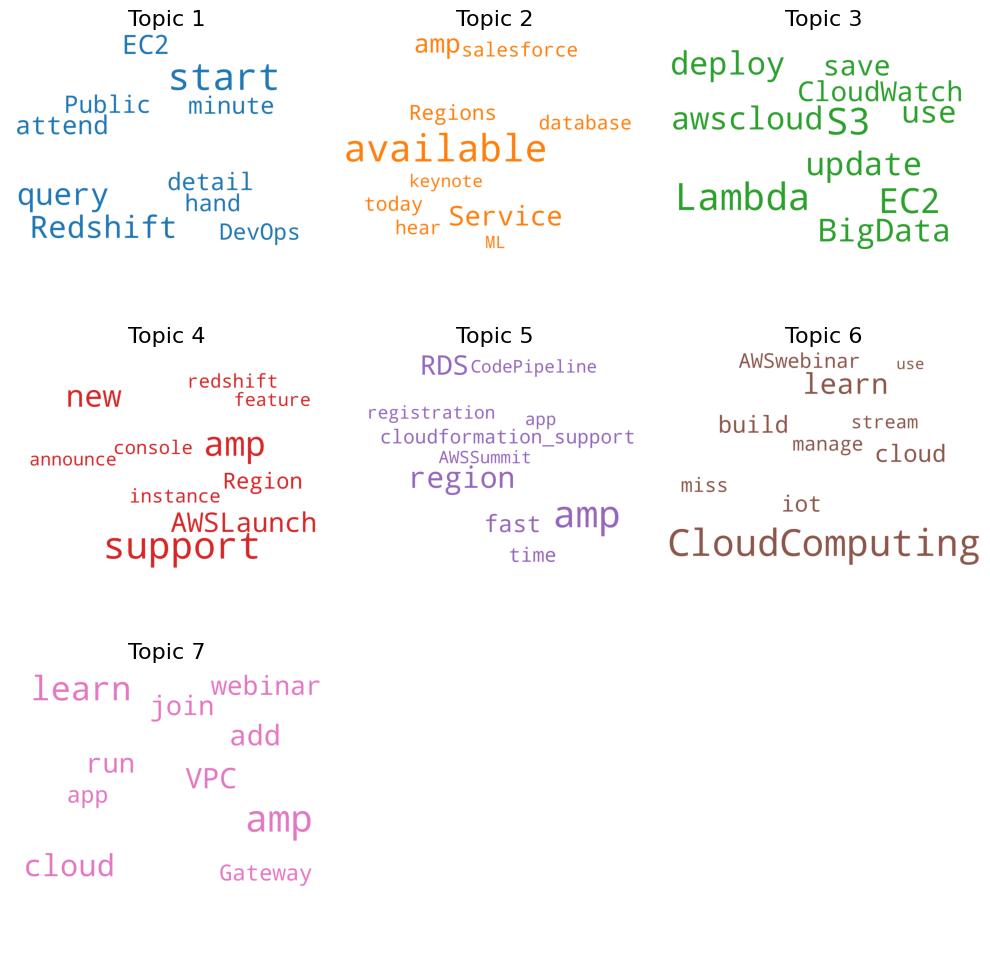

In [15]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors, math

# more colors: 'mcolors.XKCD_COLORS', fewer colors: 'mcolors.TABLEAU_COLORS'
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words_spacy, # We have already removed stop words, but just in case
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

matrix_size = math.ceil(num_topics**(1/2))  # Computes the n by n number of plots to generate
fig, axes = plt.subplots(matrix_size, matrix_size, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  try:
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')
  except:
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

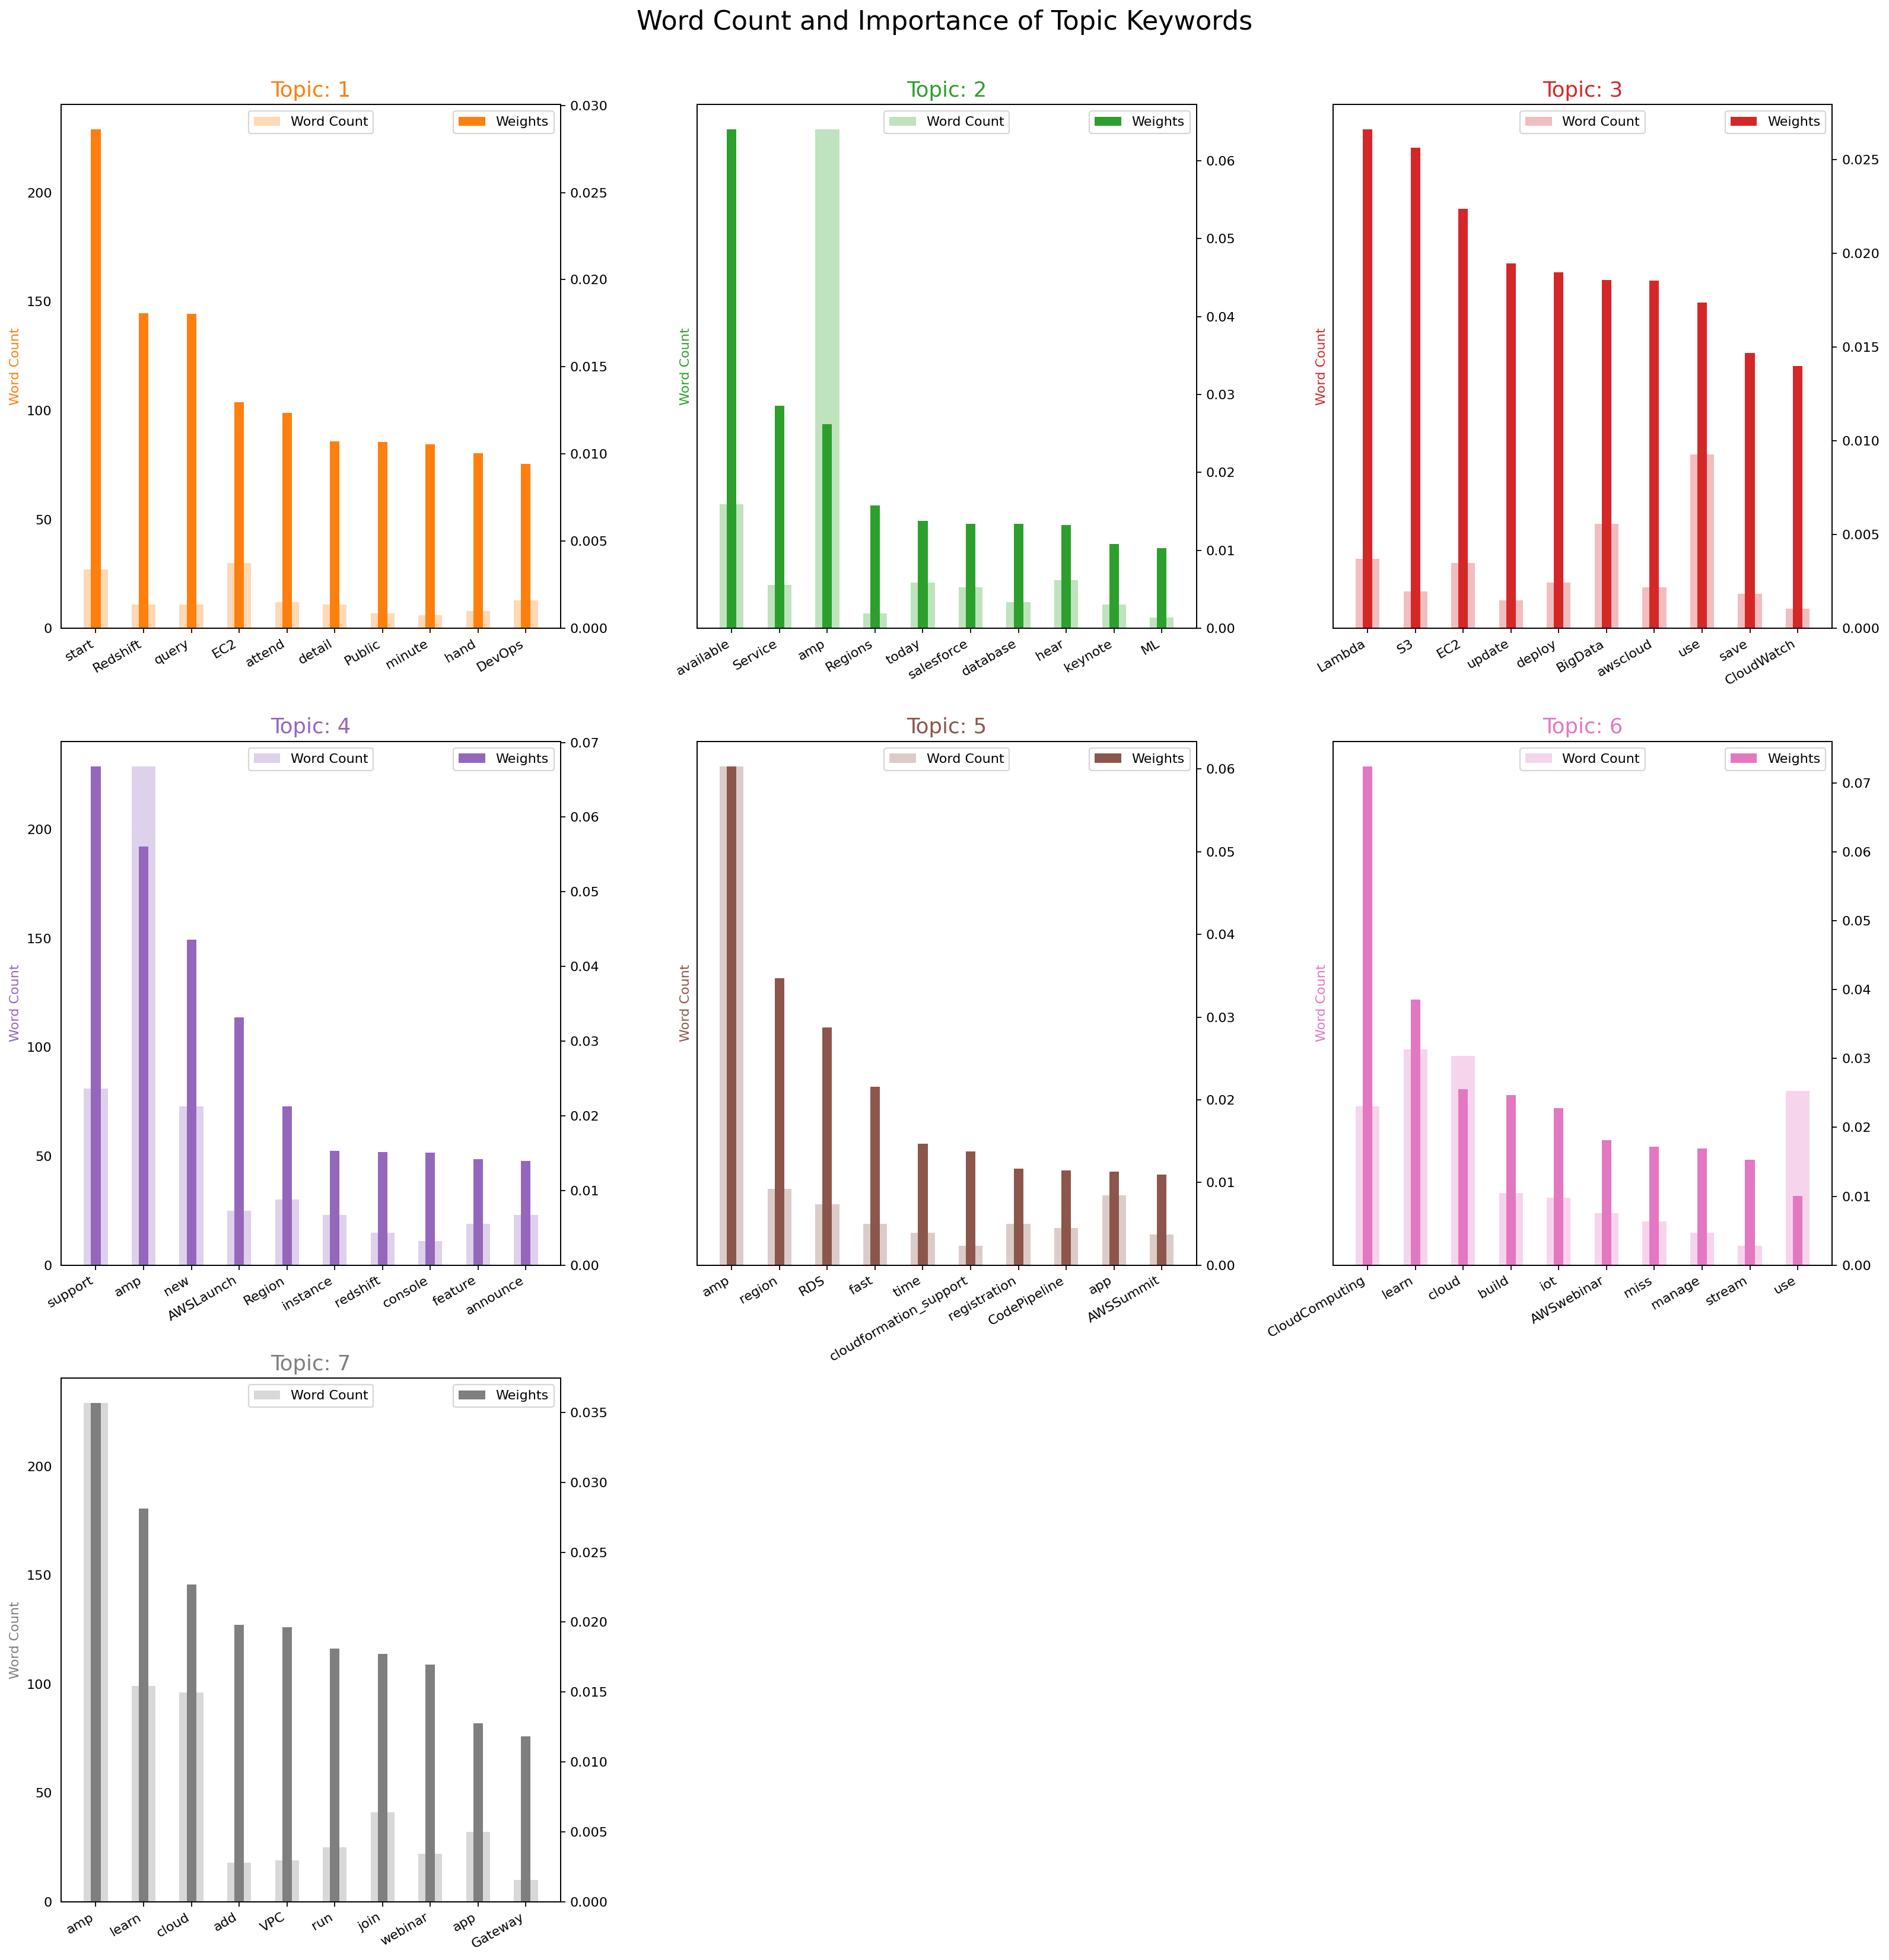

In [16]:
# Bar chart of word counts for each topic
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
  for word, weight in topic:
    out.append([word, i + 1, weight, counter[word]])

df_temp = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
matrix_size = math.ceil(num_topics**(1/2))  # Computes the n by n number of plots to generate
fig, axes = plt.subplots(matrix_size, matrix_size, figsize=(20,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
  ax.bar(x='word', height="word_count", data=df_temp.loc[df_temp.topic_id==i+1, :], color=cols[i+1], width=0.5, alpha=0.3, label='Word Count')
  ax_twin = ax.twinx()
  ax_twin.bar(x='word', height="importance", data=df_temp.loc[df_temp.topic_id==i+1, :], color=cols[i+1], width=0.2, label='Weights')
  ax.set_ylabel('Word Count', color=cols[i+1])
  ax.set_title('Topic: ' + str(i + 1), color=cols[i+1], fontsize=16)
  ax.tick_params(axis='y', left=False)
  ax.set_xticks(ax.get_xticks())
  ax.set_xticklabels(df_temp.loc[df_temp.topic_id==i+1, 'word'], rotation=30, horizontalalignment= 'right')
  ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')
  if i >= len(topics): # Turn off the unneeded subplots
    ax.axis('off')
    ax.title.set_visible(False)
    ax_twin.axis('off')
    ax.legend().set_visible(False)
    ax_twin.legend().set_visible(False)

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=20, y=1.03)
plt.show()

In [17]:
# Get topic weights and dominant topics
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import numpy as np

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
  topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title=f"t-SNE Clustering of {num_topics} LDA Topics")
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 942 samples in 0.007s...
[t-SNE] Computed neighbors for 942 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 942 / 942
[t-SNE] Mean sigma: 0.096010
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.836632
[t-SNE] KL divergence after 1000 iterations: 0.504564


Loading BokehJS ...

In [18]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/graceogden/Documents/BYU/2024Winter/IS455/ClassCode455/myenv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=73268) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/graceogden/Documents/BYU/2024Winter/IS455/ClassCode455/myenv/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/Users/graceogden/Documents/BYU/2024Winter/IS455/ClassCode455/myenv/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/Users/graceogden/Documents/BYU/2024Winter/IS455/ClassCode455/myenv/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.003329 -0.203411       1        1  17.442968
3      0.266403  0.073683       2        1  16.251955
4      0.075739 -0.100038       3        1  16.203515
5     -0.166466 -0.064140       4        1  14.066034
2     -0.109466  0.174323       5        1  13.374626
1     -0.010697  0.046185       6        1  12.742707
0     -0.052184  0.073398       7        1   9.918195, topic_info=                Term        Freq       Total Category  logprob  loglift
134   CloudComputing   72.000000   72.000000  Default  30.0000  30.0000
198          support   77.000000   77.000000  Default  29.0000  29.0000
27         available   58.000000   58.000000  Default  28.0000  28.0000
51               amp  204.000000  204.000000  Default  27.0000  27.0000
53             learn   73.000000   73.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
1012        reinvent    3.655866    4.307745   Topic7  -5.2558   2.1467
54             share    4.063994    5.350142   Topic7  -5.1499   2.0358
217              EC2    9.081570   30.764649   Topic7  -4.3459   1.0907
931         bootcamp    4.579415    7.437429   Topic7  -5.0305   1.8258
88             Cloud    4.705786   30.366562   Topic7  -5.0033   0.4462

[281 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2158      4  0.962856           ACM
1605      2  0.979714     AWSLaunch
849       3  0.986665     AWSSummit
841       4  0.965306    AWSwebinar
1841      5  0.841708  Acceleration
...     ...       ...           ...
356       4  0.854354          view
1296      2  0.841787        volume
475       1  0.973865       webinar
363       5  0.912219          week
1119      1  0.935179             |

[270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 5, 6, 3, 2, 1])

READ TUESDAY'S CHAPTER(S)!!!!!!